# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [21]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifier

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
probs = linear_classifier.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifier.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0, 0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [10]:
probs = linear_classifier.softmax(np.array([-5, 0, 5]))
linear_classifier.cross_entropy_loss(probs, np.array([1]))

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [18]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifier.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifier.softmax_with_cross_entropy(x, 1), np.array([[1, 0, 0]], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [22]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifier.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifier.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifier.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classfier.py`

In [25]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifier.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifier.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [26]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifier.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifier.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [27]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifier.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.397363
Epoch 1, loss: 2.330354
Epoch 2, loss: 2.311002
Epoch 3, loss: 2.303897
Epoch 4, loss: 2.303257
Epoch 5, loss: 2.302898
Epoch 6, loss: 2.302564
Epoch 7, loss: 2.301815
Epoch 8, loss: 2.301252
Epoch 9, loss: 2.301256


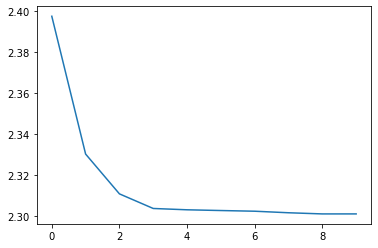

In [28]:
# let's look at the loss history!
plt.plot(loss_history)

In [29]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.127
Epoch 0, loss: 2.301800
Epoch 1, loss: 2.302558
Epoch 2, loss: 2.302208
Epoch 3, loss: 2.303309
Epoch 4, loss: 2.302126
Epoch 5, loss: 2.301524
Epoch 6, loss: 2.301150
Epoch 7, loss: 2.301359
Epoch 8, loss: 2.302305
Epoch 9, loss: 2.302205
Epoch 10, loss: 2.301595
Epoch 11, loss: 2.302039
Epoch 12, loss: 2.301247
Epoch 13, loss: 2.301836
Epoch 14, loss: 2.302396
Epoch 15, loss: 2.302299
Epoch 16, loss: 2.301161
Epoch 17, loss: 2.302058
Epoch 18, loss: 2.302180
Epoch 19, loss: 2.302339
Epoch 20, loss: 2.302694
Epoch 21, loss: 2.301872
Epoch 22, loss: 2.302261
Epoch 23, loss: 2.302209
Epoch 24, loss: 2.302215
Epoch 25, loss: 2.301591
Epoch 26, loss: 2.301535
Epoch 27, loss: 2.302557
Epoch 28, loss: 2.301689
Epoch 29, loss: 2.301815
Epoch 30, loss: 2.301483
Epoch 31, loss: 2.301553
Epoch 32, loss: 2.301640
Epoch 33, loss: 2.301991
Epoch 34, loss: 2.302104
Epoch 35, loss: 2.301741
Epoch 36, loss: 2.302652
Epoch 37, loss: 2.303017
Epoch 38, loss: 2.301521
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [31]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr in learning_rates:
    for reg in reg_strengths:
        classifier = linear_classifier.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.301406
Epoch 1, loss: 2.300645
Epoch 2, loss: 2.301930
Epoch 3, loss: 2.300194
Epoch 4, loss: 2.296883
Epoch 5, loss: 2.297291
Epoch 6, loss: 2.293188
Epoch 7, loss: 2.297095
Epoch 8, loss: 2.290985
Epoch 9, loss: 2.289429
Epoch 10, loss: 2.289858
Epoch 11, loss: 2.289787
Epoch 12, loss: 2.291270
Epoch 13, loss: 2.294006
Epoch 14, loss: 2.290483
Epoch 15, loss: 2.281833
Epoch 16, loss: 2.288653
Epoch 17, loss: 2.280844
Epoch 18, loss: 2.286164
Epoch 19, loss: 2.283487
Epoch 20, loss: 2.280167
Epoch 21, loss: 2.281047
Epoch 22, loss: 2.282983
Epoch 23, loss: 2.283910
Epoch 24, loss: 2.285083
Epoch 25, loss: 2.279782
Epoch 26, loss: 2.276024
Epoch 27, loss: 2.280392
Epoch 28, loss: 2.280157
Epoch 29, loss: 2.286447
Epoch 30, loss: 2.276390
Epoch 31, loss: 2.277262
Epoch 32, loss: 2.271290
Epoch 33, loss: 2.273131
Epoch 34, loss: 2.270356
Epoch 35, loss: 2.275901
Epoch 36, loss: 2.266546
Epoch 37, loss: 2.280699
Epoch 38, loss: 2.273933
Epoch 39, loss: 2.270175
Epoch 40, 

Epoch 125, loss: 2.239420
Epoch 126, loss: 2.207396
Epoch 127, loss: 2.205455
Epoch 128, loss: 2.220146
Epoch 129, loss: 2.232380
Epoch 130, loss: 2.229632
Epoch 131, loss: 2.245666
Epoch 132, loss: 2.232168
Epoch 133, loss: 2.212070
Epoch 134, loss: 2.214035
Epoch 135, loss: 2.219591
Epoch 136, loss: 2.213689
Epoch 137, loss: 2.231066
Epoch 138, loss: 2.214535
Epoch 139, loss: 2.227186
Epoch 140, loss: 2.222834
Epoch 141, loss: 2.214677
Epoch 142, loss: 2.229833
Epoch 143, loss: 2.227874
Epoch 144, loss: 2.200180
Epoch 145, loss: 2.223438
Epoch 146, loss: 2.205595
Epoch 147, loss: 2.230089
Epoch 148, loss: 2.206876
Epoch 149, loss: 2.225306
Epoch 150, loss: 2.203973
Epoch 151, loss: 2.230894
Epoch 152, loss: 2.213655
Epoch 153, loss: 2.213585
Epoch 154, loss: 2.226699
Epoch 155, loss: 2.195337
Epoch 156, loss: 2.212665
Epoch 157, loss: 2.212575
Epoch 158, loss: 2.225728
Epoch 159, loss: 2.200590
Epoch 160, loss: 2.227460
Epoch 161, loss: 2.210871
Epoch 162, loss: 2.228208
Epoch 163, l

Epoch 48, loss: 2.296503
Epoch 49, loss: 2.297206
Epoch 50, loss: 2.297678
Epoch 51, loss: 2.295386
Epoch 52, loss: 2.298823
Epoch 53, loss: 2.299984
Epoch 54, loss: 2.298266
Epoch 55, loss: 2.298445
Epoch 56, loss: 2.296018
Epoch 57, loss: 2.293955
Epoch 58, loss: 2.293544
Epoch 59, loss: 2.297933
Epoch 60, loss: 2.296878
Epoch 61, loss: 2.299252
Epoch 62, loss: 2.296704
Epoch 63, loss: 2.297080
Epoch 64, loss: 2.296752
Epoch 65, loss: 2.296030
Epoch 66, loss: 2.296714
Epoch 67, loss: 2.292626
Epoch 68, loss: 2.298876
Epoch 69, loss: 2.294463
Epoch 70, loss: 2.293619
Epoch 71, loss: 2.294193
Epoch 72, loss: 2.296057
Epoch 73, loss: 2.294224
Epoch 74, loss: 2.296006
Epoch 75, loss: 2.297610
Epoch 76, loss: 2.294625
Epoch 77, loss: 2.296302
Epoch 78, loss: 2.293777
Epoch 79, loss: 2.295422
Epoch 80, loss: 2.293928
Epoch 81, loss: 2.294437
Epoch 82, loss: 2.295817
Epoch 83, loss: 2.294605
Epoch 84, loss: 2.294844
Epoch 85, loss: 2.293008
Epoch 86, loss: 2.294338
Epoch 87, loss: 2.292312


Epoch 172, loss: 2.291652
Epoch 173, loss: 2.279160
Epoch 174, loss: 2.287349
Epoch 175, loss: 2.286837
Epoch 176, loss: 2.289794
Epoch 177, loss: 2.284022
Epoch 178, loss: 2.287745
Epoch 179, loss: 2.282112
Epoch 180, loss: 2.287697
Epoch 181, loss: 2.285027
Epoch 182, loss: 2.284646
Epoch 183, loss: 2.287859
Epoch 184, loss: 2.284053
Epoch 185, loss: 2.286864
Epoch 186, loss: 2.286501
Epoch 187, loss: 2.285809
Epoch 188, loss: 2.291108
Epoch 189, loss: 2.281090
Epoch 190, loss: 2.281911
Epoch 191, loss: 2.285369
Epoch 192, loss: 2.282304
Epoch 193, loss: 2.284124
Epoch 194, loss: 2.281656
Epoch 195, loss: 2.286627
Epoch 196, loss: 2.291401
Epoch 197, loss: 2.285764
Epoch 198, loss: 2.289450
Epoch 199, loss: 2.289842
Epoch 0, loss: 2.302848
Epoch 1, loss: 2.302363
Epoch 2, loss: 2.302331
Epoch 3, loss: 2.301634
Epoch 4, loss: 2.301261
Epoch 5, loss: 2.302085
Epoch 6, loss: 2.302478
Epoch 7, loss: 2.300776
Epoch 8, loss: 2.300690
Epoch 9, loss: 2.301700
Epoch 10, loss: 2.302105
Epoch 1

Epoch 97, loss: 2.302004
Epoch 98, loss: 2.301276
Epoch 99, loss: 2.301358
Epoch 100, loss: 2.301265
Epoch 101, loss: 2.302163
Epoch 102, loss: 2.301310
Epoch 103, loss: 2.301126
Epoch 104, loss: 2.301277
Epoch 105, loss: 2.302362
Epoch 106, loss: 2.301593
Epoch 107, loss: 2.301462
Epoch 108, loss: 2.302452
Epoch 109, loss: 2.302349
Epoch 110, loss: 2.300532
Epoch 111, loss: 2.300761
Epoch 112, loss: 2.301019
Epoch 113, loss: 2.300554
Epoch 114, loss: 2.300401
Epoch 115, loss: 2.301676
Epoch 116, loss: 2.302088
Epoch 117, loss: 2.301514
Epoch 118, loss: 2.301605
Epoch 119, loss: 2.301993
Epoch 120, loss: 2.302446
Epoch 121, loss: 2.303151
Epoch 122, loss: 2.301022
Epoch 123, loss: 2.301568
Epoch 124, loss: 2.301296
Epoch 125, loss: 2.302223
Epoch 126, loss: 2.302829
Epoch 127, loss: 2.302186
Epoch 128, loss: 2.300724
Epoch 129, loss: 2.300979
Epoch 130, loss: 2.302279
Epoch 131, loss: 2.300683
Epoch 132, loss: 2.301268
Epoch 133, loss: 2.301494
Epoch 134, loss: 2.300601
Epoch 135, loss

Epoch 19, loss: 2.302659
Epoch 20, loss: 2.302796
Epoch 21, loss: 2.302164
Epoch 22, loss: 2.302594
Epoch 23, loss: 2.303413
Epoch 24, loss: 2.302766
Epoch 25, loss: 2.302437
Epoch 26, loss: 2.302886
Epoch 27, loss: 2.302055
Epoch 28, loss: 2.302725
Epoch 29, loss: 2.302417
Epoch 30, loss: 2.301905
Epoch 31, loss: 2.302062
Epoch 32, loss: 2.302047
Epoch 33, loss: 2.301432
Epoch 34, loss: 2.300573
Epoch 35, loss: 2.301218
Epoch 36, loss: 2.302336
Epoch 37, loss: 2.302672
Epoch 38, loss: 2.301824
Epoch 39, loss: 2.301961
Epoch 40, loss: 2.301638
Epoch 41, loss: 2.302695
Epoch 42, loss: 2.302018
Epoch 43, loss: 2.302044
Epoch 44, loss: 2.301666
Epoch 45, loss: 2.301678
Epoch 46, loss: 2.301064
Epoch 47, loss: 2.302460
Epoch 48, loss: 2.301307
Epoch 49, loss: 2.302604
Epoch 50, loss: 2.302322
Epoch 51, loss: 2.301969
Epoch 52, loss: 2.302229
Epoch 53, loss: 2.301945
Epoch 54, loss: 2.301427
Epoch 55, loss: 2.301778
Epoch 56, loss: 2.302620
Epoch 57, loss: 2.302596
Epoch 58, loss: 2.301650


# Какой же точности мы добились на тестовых данных?

In [32]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.195000
